In [79]:
import json
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models import BasicRNN, RNN_New
from dataset import NormalizedProfilesDataset
from utils import load_normalization_metadata, load_config

import warnings

from transformer_model import AtmosphericModel

# Suppress FutureWarning for torch.load
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r"You are using `torch.load` with `weights_only=False`.*"
)

plt.style.use('science')

In [80]:

input_params = load_config('Inputs/parameters.json')

num_points = input_params['pressure_range']['points']

In [81]:
# Paths
model_params_path = "Data/Model/model_parameters.json"
model_save_path = "Data/Model/best_model.pth"
data_folder = "Data/Normalized_Profiles"
save_path = "Figures"

# Load the model parameters
with open(model_params_path, 'r') as f:
    model_params = json.load(f)

# Display the model parameters
print("Loaded model parameters:")
print(json.dumps(model_params, indent=4))

Loaded model parameters:
{
    "nx": 3,
    "ny": 1,
    "nneur": [
        32,
        32
    ],
    "batch_size": 8,
    "learning_rate": 0.0001,
    "epochs": 100,
    "input_variables": [
        "pressure",
        "temperature",
        "flux_surface_down"
    ],
    "target_variables": [
        "net_flux"
    ]
}


In [85]:
import torch
import json

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model_from_file(model_config_path, model_save_path):
    """
    Load model parameters from a JSON file and initialize the model.

    Parameters:
        model_config_path (str): Path to the JSON file containing model configuration.
        model_save_path (str): Path to the saved model weights.

    Returns:
        model (torch.nn.Module): Loaded and initialized model ready for evaluation.
    """
    # Load model parameters from JSON file
    with open(model_config_path, 'r') as file:
        model_params = json.load(file)

    # Initialize the model
    model = AtmosphericModel(
        nx=model_params['nx'],
        ny=model_params['ny'],
        nneur=tuple(model_params.get('nneur', (64, 64)))
    )

    # Load the trained model weights
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.to(device)
    model.eval()

    print("Model loaded and ready for evaluation.")
    return model

# Example usage
model_config_path = "Data/Model/model_parameters.json"
model_save_path = "Data/Model/best_model.pth"
model = load_model_from_file(model_config_path, model_save_path)


Model loaded and ready for evaluation.


In [86]:
# Load normalization metadata
normalization_metadata = load_normalization_metadata()

# Get the model metadata
input_vars = model_params['input_variables']
target_vars = model_params['target_variables']
nx = model_params['nx']


# Read the JSON file
with open('Data/Profiles/prof_1.json', "r") as file:
    prof1 = json.load(file)

print()

# Expected length of profiles
expected_length = len(prof1['pressure'])

# Initialize the test dataset
test_dataset = NormalizedProfilesDataset(
    data_folder,
    expected_length=num_points,
    input_variables=input_vars,
    target_variables=target_vars
)

# Create DataLoader
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

print("Test dataset loaded.")



Test dataset loaded.


In [87]:
print(test_dataset)

In [88]:
def denormalize(norm_values, metadata, variable_name, method):
    """
    Denormalize a given variable based on the provided normalization method and metadata.

    Parameters:
        norm_values (array or tensor): Normalized values.
        metadata (dict): Dictionary containing normalization metadata.
        variable_name (str): Name of the variable to denormalize (e.g., 'pressure', 'net_flux').
        method (str): Normalization method used ('min-max', 'standard', 'robust').

    Returns:
        Denormalized values. For pressure, returns values in Bar.
    """
    if method == "min-max":
        # For min-max, assume stored values in metadata are in log-scale for pressure.
        min_val = metadata[variable_name]["min"]
        max_val = metadata[variable_name]["max"]
        denorm = norm_values * (max_val - min_val) + min_val

        # Convert log-pressure to pressure (if this is pressure)
        if variable_name == 'pressure':
            denorm = 10 ** denorm

    elif method == "standard":
        # For standardization, assume mean and std in metadata
        mean_val = metadata[variable_name]["mean"]
        std_val = metadata[variable_name]["std"]
        denorm = norm_values * std_val + mean_val

        # Convert log-pressure to pressure if this is pressure
        if variable_name == 'pressure':
            denorm = 10 ** denorm

    elif method == "robust":
        # For robust scaling, use median and IQR (interquartile range)
        median_val = metadata[variable_name]["median"]
        iqr_val = metadata[variable_name]["iqr"]  # IQR: Interquartile range (75th percentile - 25th percentile)
        denorm = norm_values * iqr_val + median_val

        # Convert log-pressure to pressure if this is pressure
        if variable_name == 'pressure':
            denorm = 10 ** denorm

    else:
        raise ValueError(f"Unsupported normalization method: {method}")

    return denorm


Prediction time for profile 1: 1.29e-03 seconds
Prediction time for profile 2: 1.29e-03 seconds
Prediction time for profile 3: 1.63e-03 seconds
Prediction time for profile 4: 1.82e-03 seconds
Prediction time for profile 5: 1.10e-03 seconds
Prediction time for profile 6: 8.20e-04 seconds
Prediction time for profile 7: 7.39e-04 seconds
Prediction time for profile 8: 1.29e-03 seconds
Prediction time for profile 9: 1.40e-03 seconds
Prediction time for profile 10: 1.31e-03 seconds
Prediction time for profile 11: 9.05e-04 seconds
Prediction time for profile 12: 1.00e-03 seconds
Prediction time for profile 13: 1.07e-03 seconds
Prediction time for profile 14: 7.05e-03 seconds
Prediction time for profile 15: 2.34e-03 seconds
Prediction time for profile 16: 3.06e-03 seconds
Prediction time for profile 17: 1.56e-03 seconds
Prediction time for profile 18: 1.22e-03 seconds
Prediction time for profile 19: 2.45e-03 seconds
Prediction time for profile 20: 2.16e-03 seconds
Prediction time for profile 2

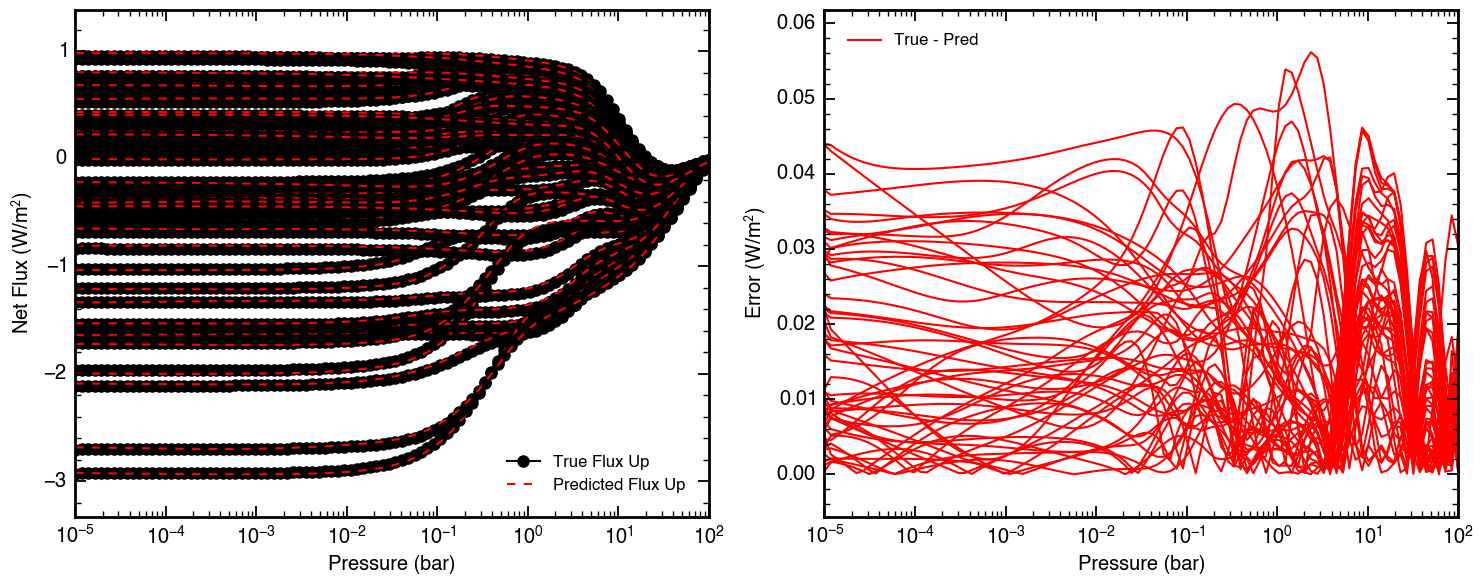

In [92]:
import time
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Number of profiles to visualize
N = 50


fractional_errors = []
# Create a directory for saving plots if it doesn't exist
os.makedirs(save_path, exist_ok=True)

with torch.no_grad():
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Two subplots side-by-side

    for idx, data in enumerate(test_loader):
        # Stop after plotting N samples
        if idx == N:
            break

        # Unpack data, ignoring extra elements if necessary
        if model_type == 'RNN_New':
            inputs, targets = data
        elif model_type == 'BasicRNN':
            inputs, targets, *_ = data  # Ignore any extra elements
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Move data to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Verify input feature size matches model expectation
        expected_nx = model_params['nx']
        actual_nx = inputs.size(-1)
        if actual_nx != expected_nx:
            raise ValueError(f"Input feature size mismatch: Model expects nx={expected_nx}, got nx={actual_nx}.")

        # Time the prediction step
        start_time = time.time()
        outputs = model(inputs_main=inputs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Prediction time for profile {idx + 1}: {elapsed_time:.2e} seconds")

        # Move tensors to CPU and convert to numpy
        inputs_np = inputs.cpu().numpy()
        targets_np = targets.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        # Denormalize pressure (assuming pressure is the first input feature)
        pressure_norm = inputs_np[:, :, 0]
        pressure_method = normalization_metadata["normalization_methods"]["pressure"]
        pressure = denormalize(pressure_norm, normalization_metadata, "pressure", pressure_method)

        # Extract flux_up from targets and outputs (assuming flux_up is index 0)
        net_flux_true_norm = targets_np[:, :, 0]  # shape: (batch, seq_len)
        net_flux_pred_norm = outputs_np[:, :, 0]  # shape: (batch, seq_len)

        # Denormalize flux_up
        net_flux_method = normalization_metadata["normalization_methods"]["net_flux"]
        net_flux_true = denormalize(net_flux_true_norm, normalization_metadata, "net_flux", net_flux_method)
        net_flux_pred = denormalize(net_flux_pred_norm, normalization_metadata, "net_flux", net_flux_method)

        # Calculate fractional error
        fractional_error = np.abs(net_flux_pred - net_flux_true) / (np.abs(net_flux_true) + 1e-10)
        error = np.abs(net_flux_pred - net_flux_true)

        fractional_errors.append(fractional_error)

        # Plot results
        # Assuming batch_size=1 for simplicity; if >1, you may need to select which sample to plot
        if idx == 0:
            axes[0].plot(pressure[0], net_flux_true[0] / 1e6, label='True Flux Up', marker='o', color='black')
            axes[0].plot(pressure[0], net_flux_pred[0] /1e6, label='Predicted Flux Up', linestyle='--', color='red')
            #axes[1].plot(pressure[0], error[0] * 100, label=r'Error (W/m$^2$)', color='red')
            axes[1].plot(pressure[0], error[0] / 1e6, label=r'True - Pred', color='red')
        else:
            axes[0].plot(pressure[0], net_flux_true[0]/1e6, marker='o', color='black')
            axes[0].plot(pressure[0], net_flux_pred[0]/1e6, linestyle='--', color='red')
            axes[1].plot(pressure[0], error[0] / 1e6, color='red')

    # Configure the left subplot (True vs Predicted Flux Up)
    #axes[0].set_yscale('symlog')
    #axes[1].set_yscale('symlog')


    axes[0].set_xscale('log')
    #axes[0].invert_xaxis()
    axes[0].set_xlabel('Pressure (bar)')
    axes[0].set_ylabel(r'Net Flux (W/m$^2$)')
    axes[0].legend(loc='best')

    # Configure the right subplot (Fractional Error)
    #axes[1].set_ylim(0, 5)  # Adjust as needed
    axes[1].set_xscale('log')
    #axes[1].invert_xaxis()
    axes[1].set_xlabel('Pressure (bar)')
    axes[1].set_ylabel(r'Error (W/m$^2$)')
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "flux_up_comparison.png"))
    plt.show()


Condensed model structure graph saved as condensed_model_structure.png


In [68]:
print(model_params)

{'model_type': 'RNN_New', 'RNN_type': 'Transformer', 'nx': 3, 'ny': 1, 'nneur': [32, 32], 'outputs_one_longer': False, 'concat': False, 'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 500, 'input_variables': ['pressure', 'temperature', 'flux_surface_down'], 'target_variables': ['net_flux']}
